# Semantic Image Segmentation

Semantic segmentation is a computer vision technique that involves dividing an image into meaningful and coherent segments or regions based on their semantic properties such as object, background, and foreground. Unlike simple image segmentation techniques that group pixels based on their color, texture, or intensity, semantic segmentation goes further by associating each segment with a semantic label that represents the class or category of the object that it belongs to.

The objective of semantic segmentation is to create a precise pixel-level map of the image that assigns a unique label to each pixel based on its semantic content. This technique has many applications in computer vision, including object recognition, scene understanding, and autonomous navigation.

To achieve semantic segmentation, deep learning models like Fully Convolutional Neural Networks (FCN), U-Net, and SegNet have been developed. These models use a combination of convolutional neural networks (CNN) and upsampling techniques to produce a pixel-level segmentation of an input image. The training of these models involves feeding a large dataset of annotated images into the network, which learns to extract features and make semantic predictions.

Overall, semantic segmentation is a powerful tool in computer vision that enables machines to interpret images at a higher level of abstraction, allowing for more advanced applications in fields like self-driving cars, robotics, and medical imaging.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Cars Segmentation Dataset

This is a sample semantic image segmentation dataset. It contains images of cars and their segmentation masks. Most of the images were taken from side of the car. Image and its corresponding mask have the same name. For example, 003.png in the "masks" folder corresponds to the 003.png file in the "images" folder. Each pixel in a mask shows the class of the corresponding pixel in the corresponding image. For example, if value of pixel (3, 7) is 1, it means pixel (3,7) in the corresponding image belongs to class 1. We have following 5 classes in this dataset:

- 0 - background
- 1 - car
- 2 - wheel
- 3 - light
- 4 - windows

https://www.kaggle.com/datasets/intelecai/car-segmentation

In [2]:
# !gdown https://drive.google.com/file/d/1BUylbm5aD82v7Q-R6L-tEEX39SnWqRj3/view?usp=sharing --fuzzy

In [3]:
# !unzip /content/car-segmentation.zip

In [4]:
IMAGE_train_PATH = "/kaggle/input/citymain/A3_Dataset/A3_Dataset/A3_Dataset/dataset1/images_prepped_train/"
IMAGE_test_PATH = "/kaggle/input/citymain/A3_Dataset/A3_Dataset/A3_Dataset/dataset1/images_prepped_test/"
MASK_train_PATH = "/kaggle/input/citymain/A3_Dataset/A3_Dataset/A3_Dataset/dataset1/annotations_prepped_train/"
MASK_test_PATH = "/kaggle/input/citymain/A3_Dataset/A3_Dataset/A3_Dataset/dataset1/annotations_prepped_test/"

In [5]:
n_classes = 12
name = []
def create_df(img_path):
    #name = []
    for dirname, _, filenames in os.walk(img_path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_train = create_df(IMAGE_train_PATH)
df_test = create_df(IMAGE_test_PATH)
print('Total Images: ', len(df_train))

Total Images:  367


In [6]:
X_trainval, X_test = train_test_split(df_train['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.1, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

# X_train = df_train['id'].values
# X_test = df_test['id'].values

Train Size   :  297
Val Size     :  33
Test Size    :  37


In [7]:
import matplotlib
print(matplotlib.rcParams['image.cmap'])

viridis


Image Size (360, 480, 3)
Mask Size (360, 480)


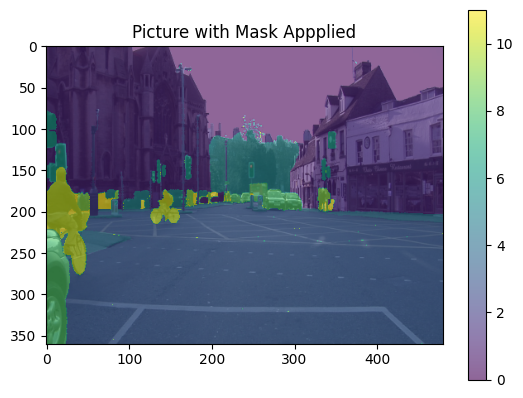

In [8]:
img = Image.open(IMAGE_train_PATH + '/' + df_train['id'][100] + '.png')
mask = Image.open(MASK_train_PATH + '/' + df_train['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

In [9]:
from torchvision import transforms as T

class CarDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = CarDataset(IMAGE_train_PATH, MASK_train_PATH, X_trainval, mean, std, t_train)
val_set = CarDataset(IMAGE_train_PATH, MASK_train_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 8 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [11]:
  for image_batch, labels in tqdm(train_loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch
    labels = labels

  0%|          | 0/42 [00:00<?, ?it/s]

# Models

# Segnet

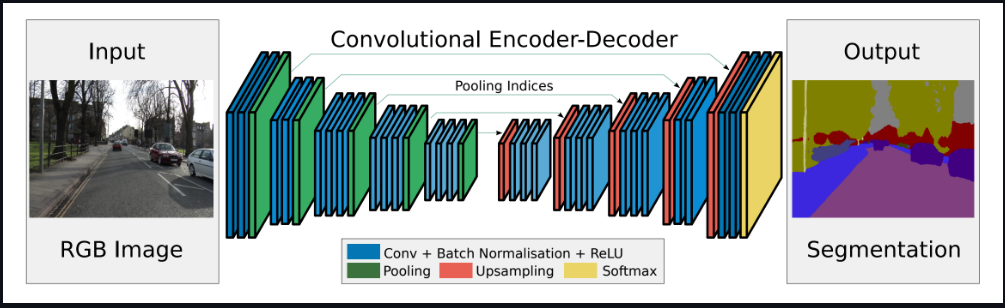

In [12]:
class _ASPP(nn.Module): 
     """ 
     Atrous spatial pyramid pooling (ASPP) 
     """ 
 
     def __init__(self, in_ch, out_ch, rates): 
         super(_ASPP, self).__init__() 
         for i, rate in enumerate(rates): 
             self.add_module( 
                 "c{}".format(i), 
                 nn.Conv2d(in_ch, out_ch, 3, 1, padding=rate, dilation=rate, bias=True), 
             ) 
  
         for m in self.children(): 
             nn.init.normal_(m.weight, mean=0, std=0.01) 
             nn.init.constant_(m.bias, 0) 
 
     def forward(self, x): 
         return sum([stage(x) for stage in self.children()]) 

In [13]:
_ASPP(3,12,[6,8])

_ASPP(
  (c0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
  (c1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
)

In [14]:
import torch.nn.functional as F


class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        x = F.softmax(x, dim=1)

        return x


model = SegNet(3,12)

# https://github.com/vinceecws/SegNet_PyTorch

## UNet

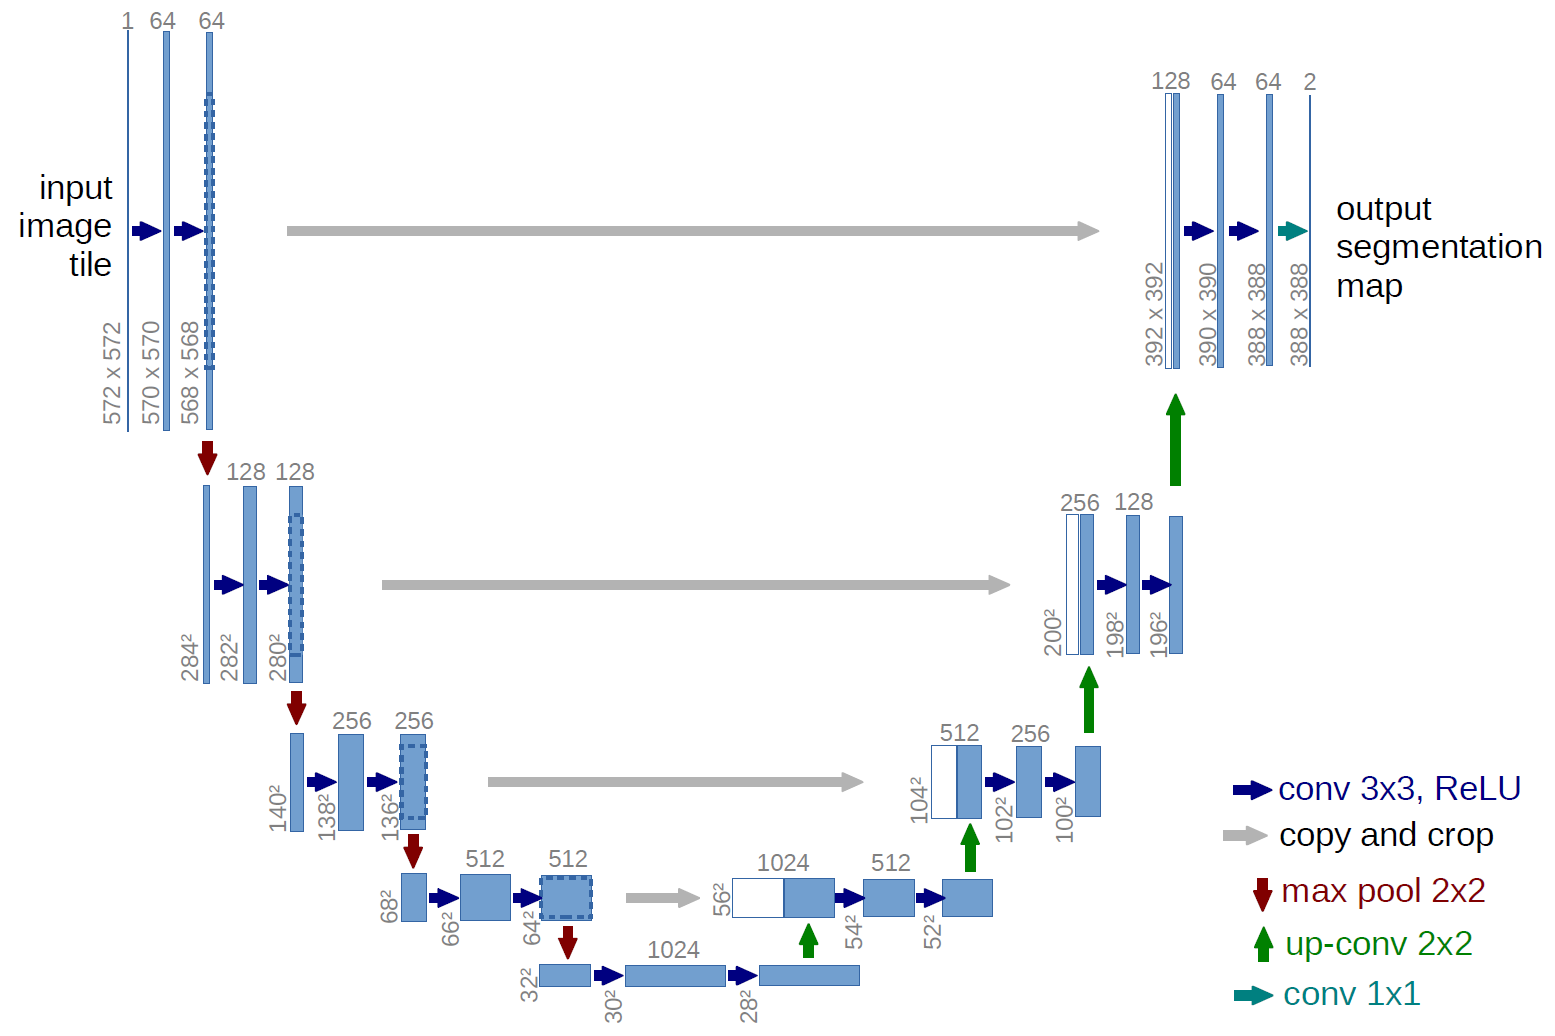

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [16]:
""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

model = UNet(3, 12)

# https://github.com/milesial/Pytorch-UNet

## Pretrained Segmentation Models Pytorch
## UNet with MobileNet Encoder

https://github.com/qubvel/segmentation_models.pytorch

In [17]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp


model = smp.Unet('efficientnet-b3', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 199MB/s]


In [18]:
# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [20]:
# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=12):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [21]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    #output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    #total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

### Training Configuration

In [22]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs =20

model.to(device);

In [23]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/kaggle/working/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/kaggle/working/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

### Main training loop

In [24]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

  

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.2433
val loss: 0.8756
train_accuracy 0.78
val_accuracy 0.64
train_IoU 0.25
val_IoU 0.22
New max val mean IoU Acheived 0.22. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.6621
val loss: 0.6165
train_accuracy 0.78
val_accuracy 0.79
train_IoU 0.32
val_IoU 0.31
New max val mean IoU Acheived 0.31. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.5777
val loss: 0.6324
train_accuracy 0.84
val_accuracy 0.70
train_IoU 0.37
val_IoU 0.29
val mean IoU did not increase from 0.31


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.4966
val loss: 0.5317
train_accuracy 0.84
val_accuracy 0.87
train_IoU 0.39
val_IoU 0.40
New max val mean IoU Acheived 0.40. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.4677
val loss: 0.4056
train_accuracy 0.81
val_accuracy 0.88
train_IoU 0.35
val_IoU 0.44
New max val mean IoU Acheived 0.44. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.4267
val loss: 0.3914
train_accuracy 0.86
val_accuracy 0.87
train_IoU 0.43
val_IoU 0.43
val mean IoU did not increase from 0.44


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.4087
val loss: 0.3421
train_accuracy 0.82
val_accuracy 0.91
train_IoU 0.35
val_IoU 0.40
val mean IoU did not increase from 0.44


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3779
val loss: 0.3156
train_accuracy 0.91
val_accuracy 0.97
train_IoU 0.45
val_IoU 0.50
New max val mean IoU Acheived 0.50. Saving model.


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3709
val loss: 0.3277
train_accuracy 0.89
val_accuracy 0.87
train_IoU 0.51
val_IoU 0.47
val mean IoU did not increase from 0.50


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3489
val loss: 0.3128
train_accuracy 0.92
val_accuracy 0.91
train_IoU 0.48
val_IoU 0.46
val mean IoU did not increase from 0.50


Epoch 10: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3471
val loss: 0.2911
train_accuracy 0.88
val_accuracy 0.95
train_IoU 0.40
val_IoU 0.44
val mean IoU did not increase from 0.50


Epoch 11: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3430
val loss: 0.3165
train_accuracy 0.84
val_accuracy 0.91
train_IoU 0.47
val_IoU 0.50
val mean IoU did not increase from 0.50


Epoch 12: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3417
val loss: 0.4104
train_accuracy 0.85
val_accuracy 0.79
train_IoU 0.42
val_IoU 0.40
val mean IoU did not increase from 0.50


Epoch 13: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3196
val loss: 0.2702
train_accuracy 0.88
val_accuracy 0.94
train_IoU 0.47
val_IoU 0.53
New max val mean IoU Acheived 0.53. Saving model.


Epoch 14: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3191
val loss: 0.3066
train_accuracy 0.90
val_accuracy 0.87
train_IoU 0.51
val_IoU 0.43
val mean IoU did not increase from 0.53


Epoch 15: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3147
val loss: 0.2730
train_accuracy 0.87
val_accuracy 0.94
train_IoU 0.43
val_IoU 0.51
val mean IoU did not increase from 0.53


Epoch 16: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.3010
val loss: 0.2835
train_accuracy 0.88
val_accuracy 0.89
train_IoU 0.48
val_IoU 0.41
val mean IoU did not increase from 0.53


Epoch 17: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.2838
val loss: 0.2517
train_accuracy 0.85
val_accuracy 0.92
train_IoU 0.43
val_IoU 0.62
New max val mean IoU Acheived 0.62. Saving model.


Epoch 18: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.2789
val loss: 0.2322
train_accuracy 0.85
val_accuracy 0.96
train_IoU 0.47
val_IoU 0.50
val mean IoU did not increase from 0.62


Epoch 19: Train 
Learning Rate: 0.001000


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.2755
val loss: 0.2343
train_accuracy 0.86
val_accuracy 0.93
train_IoU 0.51
val_IoU 0.63
New max val mean IoU Acheived 0.63. Saving model.




Text(0.5, 1.0, 'Training and val mIoU')

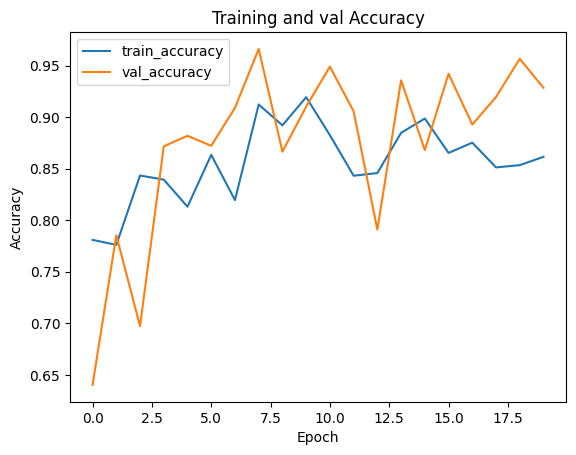

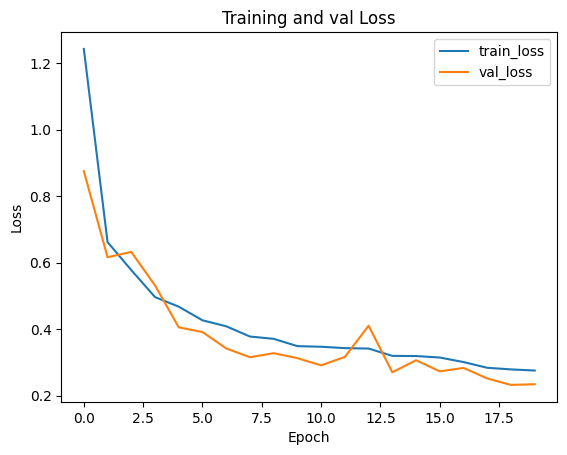

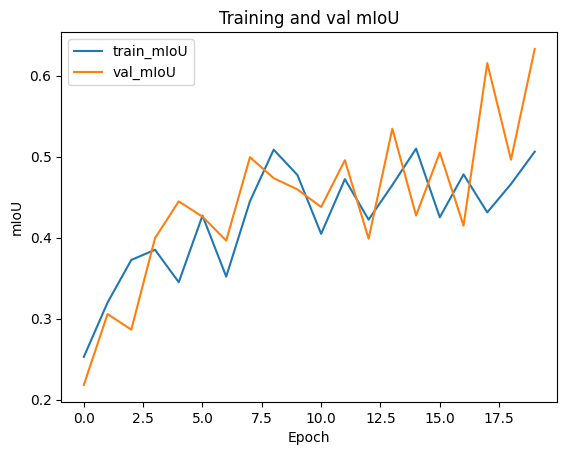

In [25]:
plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_mIoUs, label="train_mIoU")
plt.plot(val_mIoUs, label="val_mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and val mIoU')

# Evaluation

In [26]:
# !gdown https://drive.google.com/file/d/1-I2Up6QlCZrw0M_9BjwbEkE_TW5QnHJL/view?usp=share_link --fuzzy

In [27]:
best_val_model_path = '/kaggle/working/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

In [29]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    #     t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #     image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [30]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

In [31]:
mob_miou = test_miou_score(model, val_set)
np.mean(mob_miou)

  0%|          | 0/33 [00:00<?, ?it/s]

0.5369947418782726

In [32]:
check_accuracy(val_loader,model,device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Got 4865137/25952256 with pixel accuracy 18.75
Dice score: 43.05


In [33]:
def display_for_comparison(image, mask, pred_mask):

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-EfficientNetB0 | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

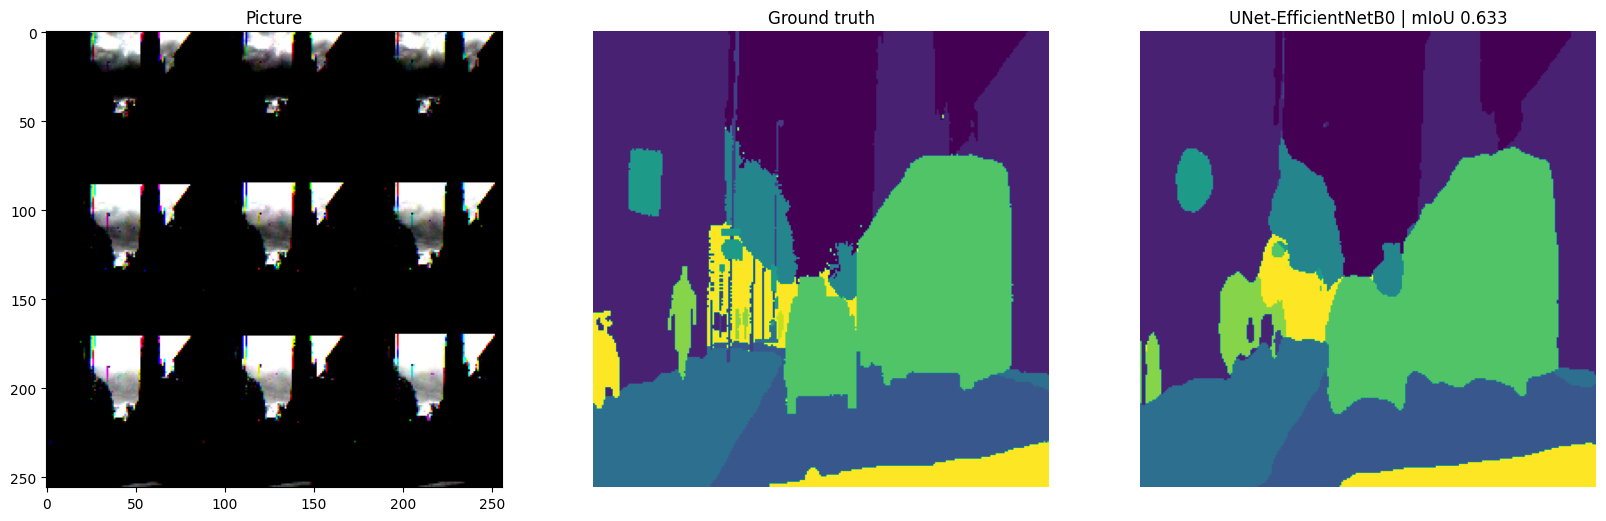

In [34]:
image, mask = val_set[0]
pred_mask, score = predict_image_mask_miou(model, image, mask)

display_for_comparison(image.numpy().reshape(256,256,3), mask, pred_mask)

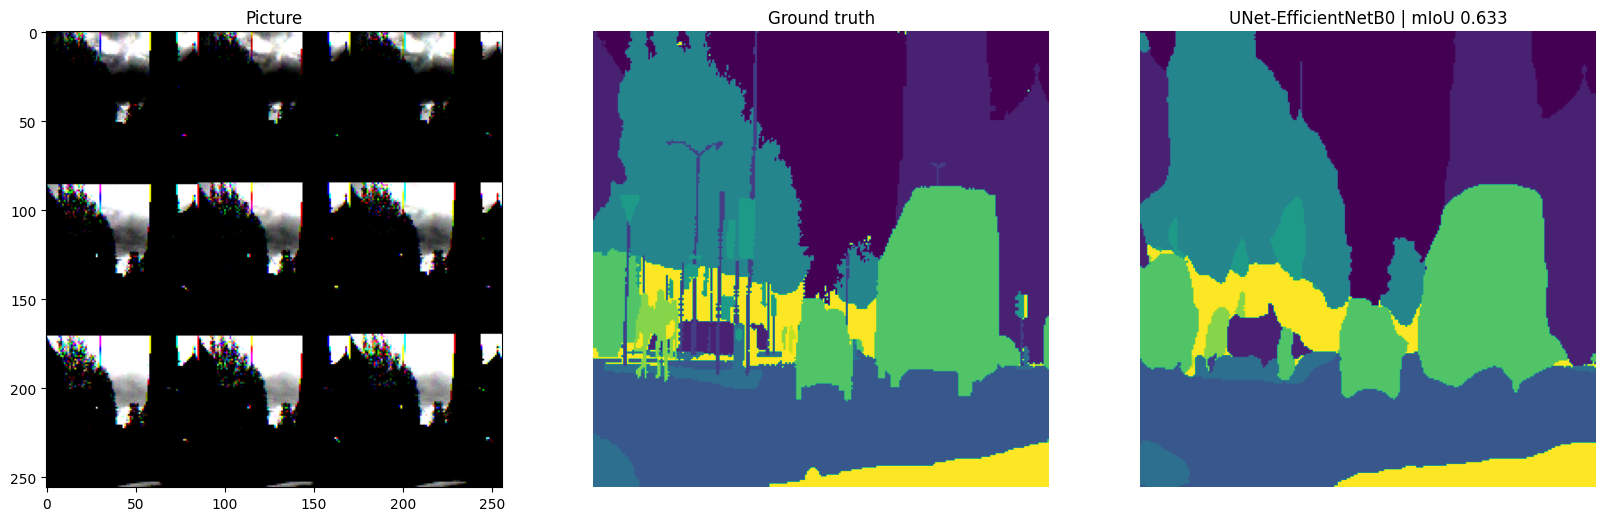

In [35]:
image2, mask2 = val_set[9]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)


display_for_comparison(image2.numpy().reshape(256,256,3), mask2, pred_mask2)

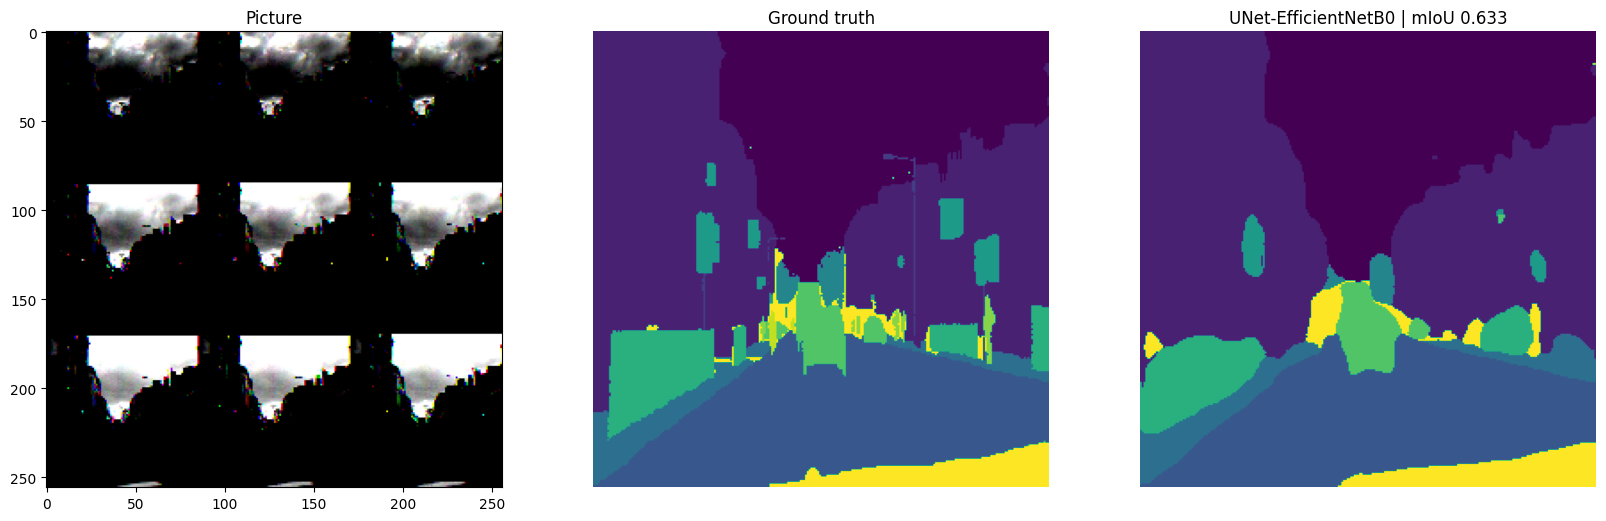

In [36]:
image3, mask3 = val_set[15]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)


display_for_comparison(image3.numpy().reshape(256,256,3), mask3, pred_mask3)

# Credits
- Notebook Prepared by Bostan Khan, Team Lead, MachVIS Lab

- https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch